In [1]:
# Install required packages
!pip -q install pandas numpy matplotlib scikit-learn joblib featuretools prophet gradio openpyxl

import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import joblib, io, os
import featuretools as ft
from prophet import Prophet
import gradio as gr
from IPython.display import display, Markdown
print('Libraries loaded.')


Libraries loaded.


In [2]:
# Download UCI Online Retail dataset (public)
# Source (UCI): https://archive.ics.uci.edu/ml/datasets/Online+Retail
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
fn = "Online_Retail.xlsx"
if not os.path.exists(fn):
    try:
        import urllib.request
        print("Downloading dataset...")
        urllib.request.urlretrieve(data_url, fn)
        print("Downloaded to", fn)
    except Exception as e:
        print("Failed to download dataset automatically. You can upload 'Online_Retail.xlsx' manually to Colab.")
        raise

# Load the Excel file
df = pd.read_excel(fn)
print("Rows:", len(df))
df.head()


Downloaded to Online_Retail.xlsx
Rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Basic preprocessing
df.columns = [c.strip() for c in df.columns]
# Keep useful columns and dropna
df = df[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']].dropna(subset=['InvoiceNo','StockCode','Quantity','InvoiceDate'])
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter to a subset of SKUs for speed (top 10 best-selling StockCodes)
top_skus = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head(10).index.tolist()
df_sub = df[df['StockCode'].isin(top_skus)].copy()
print("Selected top SKUs:", top_skus)

# Aggregate to daily sales per SKU
df_sub['date'] = df_sub['InvoiceDate'].dt.floor('d')
daily = df_sub.groupby(['date','StockCode','Description']).agg({'Quantity':'sum'}).reset_index()
daily = daily.rename(columns={'Quantity':'units_sold'})
daily.head()


Selected top SKUs: [22197, 84077, '85099B', '85123A', 84879, 21212, 23084, 22492, 22616, 21977]


,date,StockCode,Description,units_sold
0,2010-12-01,21212,PACK OF 72 RETROSPOT CAKE CASES,241
1,2010-12-01,21977,PACK OF 60 PINK PAISLEY CAKE CASES,122
2,2010-12-01,22197,SMALL POPCORN HOLDER,271
3,2010-12-01,22492,MINI PAINT SET VINTAGE,108
4,2010-12-01,22616,PACK OF 12 LONDON TISSUES,40


In [4]:
import featuretools as ft

# Reset entityset
es = ft.EntitySet(id="retail")

# Add daily sales table
daily = df.groupby(['InvoiceDate', 'StockCode']).agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

# Add date column
daily['date'] = pd.to_datetime(daily['InvoiceDate'].dt.date)
daily = daily.drop(columns=['InvoiceDate'])

# Add units_sold column (same as Quantity here, but kept explicit for clarity)
daily['units_sold'] = daily['Quantity']

# Add entity with time_index
es = es.add_dataframe(
    dataframe_name="daily_sales",
    dataframe=daily,
    index="row_id",
    make_index=True,
    time_index="date"
)

# Run deep feature synthesis (DFS) to create time-based features
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="daily_sales",
    agg_primitives=[
        "mean", "sum", "std", "max", "min", "count"
    ],
    trans_primitives=[
        "day", "month", "year", "weekday", "cum_sum", "cum_mean", "diff"
    ],
    max_depth=2
)

print("Generated feature matrix shape:", feature_matrix.shape)
feature_matrix.head()


Generated feature matrix shape: (528881, 17)


,StockCode,Quantity,UnitPrice,units_sold,CUM_MEAN(Quantity),CUM_MEAN(UnitPrice),CUM_MEAN(units_sold),CUM_SUM(Quantity),CUM_SUM(UnitPrice),CUM_SUM(units_sold),DAY(date),DIFF(Quantity),DIFF(UnitPrice),DIFF(units_sold),MONTH(date),WEEKDAY(date),YEAR(date)
row_id,,,,,,,,,,,,,,,,,
0,21730,6,4.25,6,6.000000,4.250000,6.000000,6.0,4.25,6.0,1,NaN,NaN,NaN,12,2,2010
1,22752,2,7.65,2,4.000000,5.950000,4.000000,8.0,11.90,8.0,1,-4.0,3.40,-4.0,12,2,2010
2,71053,6,3.39,6,4.666667,5.096667,4.666667,14.0,15.29,14.0,1,4.0,-4.26,4.0,12,2,2010
3,84029E,6,3.39,6,5.000000,4.670000,5.000000,20.0,18.68,20.0,1,0.0,0.00,0.0,12,2,2010
4,84029G,6,3.39,6,5.200000,4.414000,5.200000,26.0,22.07,26.0,1,0.0,0.00,0.0,12,2,2010


In [5]:
# Prepare modeling dataframe by merging forecasts and features
fm = feature_matrix.reset_index().rename(columns={'index':'row_id'})

# Reconstruct the 'date' column in fm from year, month, and day columns
fm['date'] = pd.to_datetime(fm['YEAR(date)'].astype(str) + '-' + fm['MONTH(date)'].astype(str) + '-' + fm['DAY(date)'].astype(str))

# extract useful features and target
model_df = fm.copy()
# ensure date column exists (already done above)
# if 'date' not in model_df.columns and 'daily_sales.date' in model_df.columns:
#     model_df['date'] = model_df['daily_sales.date']

# target is units_sold from original daily
model_df = model_df.merge(daily[['date','StockCode','units_sold']], on=['date','StockCode'], how='left')

# Drop the redundant units_sold_x column and rename units_sold_y
model_df = model_df.drop(columns=['units_sold_x']).rename(columns={'units_sold_y': 'units_sold'})

model_df = model_df.dropna(subset=['units_sold']).sort_values('date')
print("Model DF rows:", len(model_df))
display(model_df.head())

Model DF rows: 1653557


,row_id,StockCode,Quantity,UnitPrice,CUM_MEAN(Quantity),CUM_MEAN(UnitPrice),CUM_MEAN(units_sold),CUM_SUM(Quantity),CUM_SUM(UnitPrice),CUM_SUM(units_sold),DAY(date),DIFF(Quantity),DIFF(UnitPrice),DIFF(units_sold),MONTH(date),WEEKDAY(date),YEAR(date),date,units_sold
0,0,21730,6,4.25,6.000000,4.250000,6.000000,6.0,4.25,6.0,1,NaN,NaN,NaN,12,2,2010,2010-12-01,6
7683,1859,85123A,4,5.91,9.879032,3.568414,9.879032,18375.0,6637.25,18375.0,1,-7.0,2.55,-7.0,12,2,2010,2010-12-01,6
7684,1859,85123A,4,5.91,9.879032,3.568414,9.879032,18375.0,6637.25,18375.0,1,-7.0,2.55,-7.0,12,2,2010,2010-12-01,3
7685,1859,85123A,4,5.91,9.879032,3.568414,9.879032,18375.0,6637.25,18375.0,1,-7.0,2.55,-7.0,12,2,2010,2010-12-01,32
7686,1859,85123A,4,5.91,9.879032,3.568414,9.879032,18375.0,6637.25,18375.0,1,-7.0,2.55,-7.0,12,2,2010,2010-12-01,4


In [6]:
# Select features (drop identifiers and large object types)
drop_cols = ['row_id','date','Description'] + [c for c in model_df.columns if c.endswith('mean') and 'daily_sales' not in c]
features = [c for c in model_df.columns if c not in drop_cols and c!='units_sold' and model_df[c].dtype in [int,float]]
# simple time split: last 60 days as test
cutoff = model_df['date'].max() - pd.Timedelta(days=60)
train = model_df[model_df['date'] < cutoff]
test = model_df[model_df['date'] >= cutoff]
X_train, y_train = train[features], train['units_sold']
X_test, y_test = test[features], test['units_sold']

print("Training rows:", len(X_train), "Test rows:", len(X_test))
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train.fillna(0), y_train)

preds = rf.predict(X_test.fillna(0))
rmse = sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(y_test, preds)
display(Markdown(f'**RF RMSE:** {rmse:.2f}  |  **RF MAPE:** {mape:.2%}'))


Training rows: 1080418 Test rows: 573139


**RF RMSE:** 219.43  |  **RF MAPE:** 701455256342647.50%

Example SKU: 21730


20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
114,2012-01-02,-218.515437,-317.855753,-103.301705
115,2012-01-03,-232.055723,-331.767845,-129.639732
116,2012-01-04,-232.212375,-337.790372,-128.267396
117,2012-01-05,-190.744772,-291.399308,-92.195825
118,2012-01-06,-231.751732,-336.592790,-123.261661


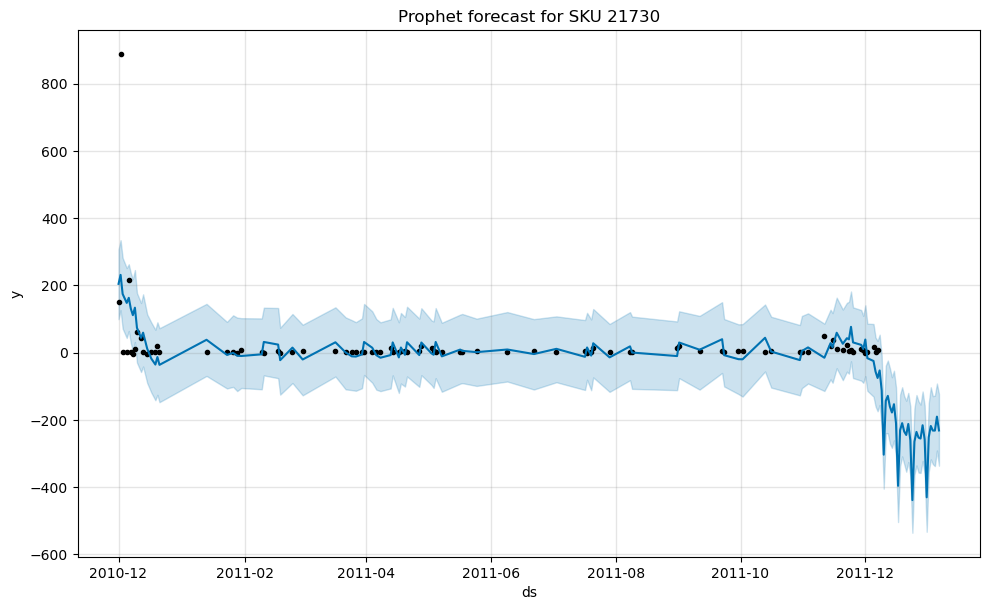

In [7]:
# Fit Prophet for one SKU as stronger time-series model example
import prophet
import matplotlib.pyplot as plt

example_sku = model_df['StockCode'].unique()[0]
print("Example SKU:", example_sku)
# Use model_df to create series for Prophet to ensure consistency with the Random Forest data
series = model_df[model_df['StockCode']==example_sku][['date','units_sold']].rename(columns={'date':'ds','units_sold':'y'}).groupby('ds').sum().reset_index()

m = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(series)
future = m.make_future_dataframe(periods=30)
fc = m.predict(future)
fig = m.plot(fc); plt.title(f"Prophet forecast for SKU {example_sku}")
fc[['ds','yhat','yhat_lower','yhat_upper']].tail()

In [8]:
from scipy.stats import norm
def compute_eoq_from_forecast(forecast_series, order_cost=500, holding_cost_per_unit_per_year=15, lead_time_days=7, service_level=0.95):
    # forecast_series: pandas Series of daily demand (length N)
    avg_daily = float(forecast_series.mean())
    annual_demand = avg_daily * 365.0
    H = holding_cost_per_unit_per_year
    S = order_cost
    D = annual_demand
    eoq = (2*D*S / H)**0.5 if H>0 else float('nan')
    sigma_daily = float(forecast_series.std(ddof=1))
    z = norm.ppf(service_level)
    safety_stock = z * sigma_daily * (lead_time_days**0.5)
    reorder_point = avg_daily * lead_time_days + safety_stock
    return dict(avg_daily=avg_daily, annual_demand=annual_demand, EOQ=eoq, SafetyStock=safety_stock, ROP=reorder_point)

# Example compute using Prophet forecast tail
prophet_forecast = fc.set_index('ds')['yhat'][-30:]
compute_eoq_from_forecast(prophet_forecast)


{'avg_daily': -231.61452905291193,
 'annual_demand': -84539.30310431286,
 'EOQ': (1.453665750497165e-13+2374.016331091158j),
 'SafetyStock': np.float64(362.0587493587696),
 'ROP': np.float64(-1259.242954011614)}

In [9]:
# Prepare a small lookup of SKU forecasts (average next-30-day) using Prophet models per SKU (for top SKUs)
sku_forecasts = {}
for sku in daily['StockCode'].unique():
    ser = daily[daily['StockCode']==sku][['date','units_sold']].groupby('date').sum().reset_index().rename(columns={'date':'ds','units_sold':'y'})
    if len(ser) < 100:
        continue
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(ser)
    fut = m.make_future_dataframe(periods=30)
    pred = m.predict(fut).set_index('ds')['yhat'][-30:]
    sku_forecasts[sku] = pred

print('Prepared forecasts for', len(sku_forecasts), 'SKUs.')

def predict_ui(stockcode):
    if stockcode not in sku_forecasts:
        return f'No forecast for SKU {stockcode} (too little data).'
    pred = sku_forecasts[stockcode]
    stats = compute_eoq_from_forecast(pred)
    return {
        'stockcode': stockcode,
        'avg_daily_forecast': round(stats['avg_daily'],2),
        'annual_demand': int(stats['annual_demand']),
        'EOQ': int(stats['EOQ']),
        'SafetyStock': int(stats['SafetyStock']),
        'ROP': int(stats['ROP'])
    }

# Gradio app
demo = gr.Interface(fn=predict_ui, inputs=gr.Dropdown(choices=list(sku_forecasts.keys()), label='StockCode'), outputs='json', title='SKU Forecast -> EOQ & Safety Stock')
demo.launch(share=False)


20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1] done processing
20:50:07 - cmdstanpy - INFO - Chain [1] start processing
20:50:07 - cmdstanpy - INFO - Chain [1]

Prepared forecasts for 1084 SKUs.
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\blocks.py", line 1781, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        fn, *processed_input, limiter=self.limiter
        ^^

Created dataset file at: .gradio\flagged\dataset1.csv


Traceback (most recent call last):
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<11 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^
  File "C:\Users\91935\anaconda3\Lib\site-packages\gradio\blocks.py", line 1781, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        fn, *processed_input, limiter=self.limiter
        ^^